<a href="https://colab.research.google.com/github/meximized/eye_pathology_detection/blob/main/CV_lab_basics(withTN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
%cd drive/MyDrive/Colab_Notebooks/Eye_images/

[Errno 2] No such file or directory: 'drive/MyDrive/Colab_Notebooks/Eye_images/'
/content/drive/MyDrive/Colab_Notebooks/Eye_images


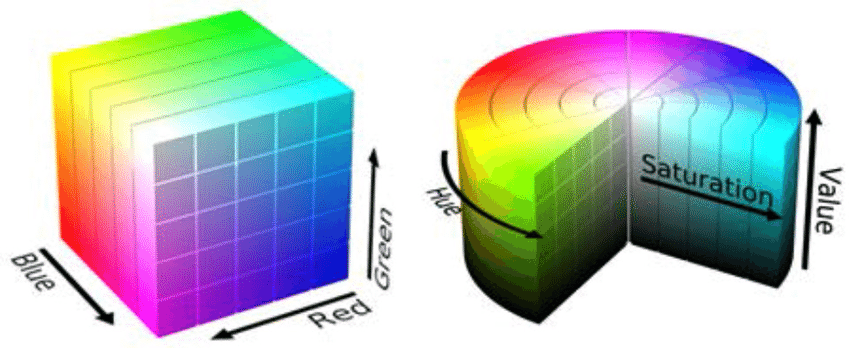

ОРИЕНТИРУЕМСЯ ДЕЛЯ ЗНАЧЕНИЕ ДЛЯ НАШЕГО ЦВЕТА НА 2

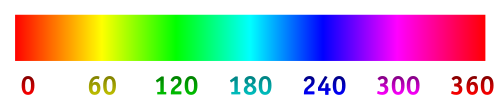

* Hue — цветовой тон, (например, красный, зелёный или сине-голубой). Варьируется в пределах 0—360°, однако иногда приводится к диапазону 0—100 или 0—1. **ЗДЕСЬ В ПРЕДЕЛАХ 0-179**
* Saturation — насыщенность. Варьируется в пределах 0—100 или 0—1. Чем больше этот параметр, тем «чище» цвет, поэтому этот параметр иногда называют чистотой цвета. А чем ближе этот параметр к нулю, тем ближе цвет к нейтральному серому. **ЗДЕСЬ В ПРЕДЕЛАХ 0-255**
* Value (значение цвета) или Brightness — яркость. Также задаётся в пределах 0—100 или 0—1. **ЗДЕСЬ В ПРЕДЕЛАХ 0-255**

In [5]:
im1 = cv2.imread('im.png', cv2.IMREAD_UNCHANGED)
im2 = cv2.imread('im_cor_greaterthan0.png', cv2.IMREAD_UNCHANGED)
im3 = cv2.imread('im_cor_lessthan0.png', cv2.IMREAD_UNCHANGED)

In [6]:
im1.shape

(983, 1280, 4)

In [7]:
im1.dtype

dtype('uint8')

In [8]:
def imconvert(image, show, *, filename = 0, back = 1):
  hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

  lower_edge = np.array([60, 0, 100]) #последним значением высекаем шум
  upper_edge = np.array([60, 255, 255])

  mask = cv2.inRange(hsv, lower_edge, upper_edge)
  result = cv2.bitwise_and(image, image, mask = mask)

  if show != 0:
    cv2_imshow(image)
    cv2_imshow(mask)
    cv2_imshow(result)

  background_pixels = 0

  if back == 1:

    lower_edge = np.array([0, 0, 0])
    upper_edge = np.array([179, 255, 25])

    back_mask = cv2.inRange(hsv, lower_edge, upper_edge)
    background = cv2.bitwise_and(image, image, mask = back_mask)

    background_alpha_channel = background[:,:,3]

    for i in range(background_alpha_channel.shape[0]): 
      for j in range(background_alpha_channel.shape[1]): 
        if background_alpha_channel[i][j] != 0:
          background_pixels += 1

 #   cv2_imshow(background)
 #   cv2.imwrite('background.png', background)

  if filename != 0:
    cv2.imwrite(filename, result)

  return background_pixels

In [9]:
imconvert(im1, 0, filename = "res.png")
imconvert(im2, 0, filename = "res2.png")
imconvert(im3, 0, filename = "res3.png")

216356

In [10]:
imconvert(im1, 0, back = 1)

216356

In [11]:
res = cv2.imread('res.png', cv2.IMREAD_UNCHANGED)
res2 = cv2.imread('res2.png', cv2.IMREAD_UNCHANGED)
res3 = cv2.imread('res3.png', cv2.IMREAD_UNCHANGED)

#cv2_imshow(res + res2)

In [12]:
res_alpha = res[:,:,3]

In [13]:
type(res_alpha), res_alpha.shape, res_alpha.max()

(numpy.ndarray, (983, 1280), 255)

У нас есть .png изображение, это трехмерный нумпай массив (число строк, число столбцов, число каналов). Число каналов в этом расширении = 4, первые три отвечают за rgb составляющие цвета, последний канал отвечает за прозрачность (0 - полностью прозрачный пиксель, 255 - полностью непрозрачный). В предыдущей функции imconvert мы отделяем метки патологий от других пикселей на изображении глазного дна так, что метки становятся единственными непрозрачными пикселями на изображениях. В следующей функции count_pixels мы считаем количество пикселей на метках с помощью подсчета непрозрачных пикселей на альфа-канале изображения. Все пиксели делим на 4 группы TP, TN, FP, FN. Дальше мы группируем эти измерения в метрики. 

Функция получает на вход исходное изображение, с которым необходимо сравнивать все остальные изображения и словарь с оставшимися искаженными изображениями детекции патологий.

Изначально мы обрабатываем альфа-канал исходного изображения и подсчитываем число пикселей на картине неискаженной детекции.

Далее мы начинаем обрабатывать искаженные изображения через маскирование и комбинации с исходным изображением:

1) False Negatives:

Берем искаженную картинку детекции и инвертируем ее, делая прозрачной только саму область детекции, а все остальные пиксели непрозрачными - это маска.
Далее мы накладываем эту маску на исходное изображение детекции. Маска у нас необычная, в данном случае прозрачные пиксели соответствующие искаженной детекции в маске представляются черными, то есть они отображают ту область, которая не отобразится на нашем исходном изображении. А отобразятся на нем только те **пиксели, которые мы не нашли на искаженной картинке, а должны были.**

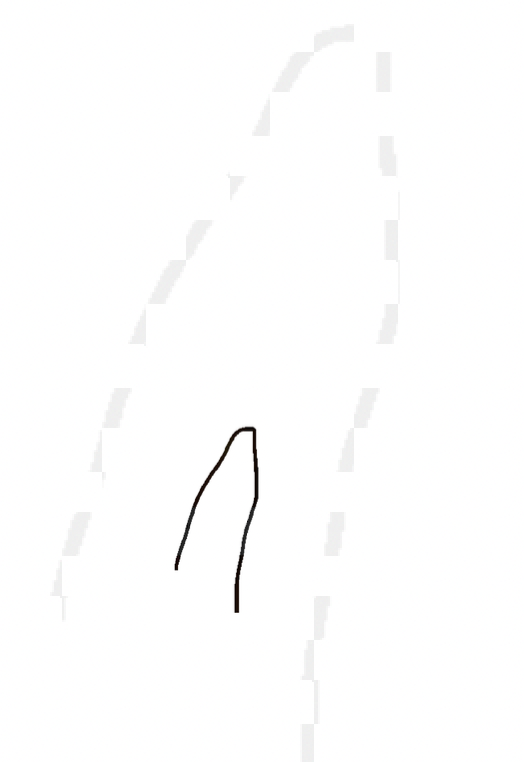

2) True Positives:

Мы берем False Negatives в качестве маски и применяем ее к исходному изображению, таким образом мы получаем те пиксели из изображения исходной детекции, которые мы правильно характеризовали как патологические с помощью детекции на искаженном изображении.

3) False Positives:

Здесь мы повторяем ту же схему, которую мы проводили в пункте 1, только меняем исходное изображение на изоблражение из массива и наоборот.

4) True Negatives:

Этих пикселей всегда будет очень много, надо как-то продумать этот момент. Для начала необходио удалить все черные пиксели за пределами изображения глазного дна, затем убрать пиксели, соответствующие картине детекции на исходном изображении. Это будет исходная картина, которая будет обрабатываться для каждого изображения искаженной детекции из массива. Так, мы удаляем все пиксели, соответствующие детекции на искаженном изображении, с этой нашей заготовки, и получаем все пиксели, которые правильно не задетектировались на искаженных картинках. (Надо подумать как быть с размытием границ на искаженных изображениях)

In [46]:
def count_pixels(orig_image, reference_image, images):
  rows = orig_image.shape[0] #потом для оптимизации работы можно эти значения вставить во все циклы где используется .shape так как везде размерности одинаковые
  cols = orig_image.shape[1]

  background_pixels = imconvert(orig_image, 0)

  total_pixels = rows * cols

  reference_image_alpha_channel = reference_image[:,:,3]

  reference_image_pathology_pixels = 0

  for i in range(reference_image_alpha_channel.shape[0]): 
    for j in range(reference_image_alpha_channel.shape[1]): 
        if reference_image_alpha_channel[i][j] != 0:
          reference_image_pathology_pixels += 1

#  cv2_imshow(reference_image)
  
  distorted_image_parameters = []

  for key, value in images.items():

    distorted_image_pixels = dict()

    #FALSE NEGATIVES
    FN_mask = cv2.bitwise_not(images[key])                # вычисляем изображение, обратное картине искаженной детекции
    FN_4_channels = cv2.bitwise_and(reference_image, FN_mask)  # FN_4_channels вычисляем след картины искаженной детекции на картине детекции без искажений

    FN_alpha = FN_4_channels[:,:,3]
    FN_pixels = 0
    for j in range(FN_alpha.shape[0]): 
      for k in range(FN_alpha.shape[1]): 
        if FN_alpha[j][k] != 0:
          FN_pixels += 1
    distorted_image_pixels['FN'] = FN_pixels

    #TRUE POSITIVES
    TP_mask = cv2.bitwise_not(FN_4_channels)              # теперь в качестве маски выступают пиксели, которые остались от оригинального изображения после того, как все остальные были убраны наложением искаженного
    TP_4_channels = cv2.bitwise_and(reference_image, TP_mask)  # TP_4_channels получаем только те пиксели, которые совпадают у исходного изображения и искаженного
 
    TP_alpha = TP_4_channels[:,:,3]
    TP_pixels = 0
    for j in range(TP_alpha.shape[0]): 
      for k in range(TP_alpha.shape[1]): 
        if TP_alpha[j][k] != 0:
          TP_pixels += 1
    distorted_image_pixels['TP'] = TP_pixels

    #FALSE POSITIVES
    FP_mask = cv2.bitwise_not(reference_image)
    FP_4_channels = cv2.bitwise_and(images[key], FP_mask)

    FP_alpha = FP_4_channels[:,:,3]
    FP_pixels = 0
    for j in range(FP_alpha.shape[0]): 
      for k in range(FP_alpha.shape[1]): 
        if FP_alpha[j][k] != 0:
          FP_pixels += 1
    distorted_image_pixels['FP'] = FP_pixels

    #TRUE NEGATIVES
    TN_pixels = total_pixels - background_pixels - FP_pixels - TP_pixels - FN_pixels
    distorted_image_pixels['TN'] = TN_pixels

    #metrics
    distorted_image_pixels['Precision'] = TP_pixels / (TP_pixels + FP_pixels)
    distorted_image_pixels['Recall'] = TP_pixels / (TP_pixels + FN_pixels)
    distorted_image_pixels['Specificity'] = TN_pixels / (TN_pixels + FP_pixels)

    distorted_image_parameters.append(distorted_image_pixels) #добавляем словарь с информацией о пикселях в общи   массив

  correlation = []
  
  for image in distorted_image_parameters:
    if image['TP'] != 0:
      correlation.append(round(image['TP']/reference_image_pathology_pixels, 4))
    else:
      correlation.append(-1)

  print('Original image pixel number = ', reference_image_pathology_pixels,'\n')

  n = 0
  image_names = list(images.keys())

  print('Distorted images pixels parameters:', '\n')
  for image in distorted_image_parameters:
    print(image_names[n], ":", 'TP:', image['TP'], '\t', 'FN:', image['FN'], '\t', 'FP:', image['FP'], '\t', 'TN:', image['TN'], 2 * '\t', 'correalation:', correlation[n], '\n')
    n += 1

  n = 0

  for image in distorted_image_parameters:
    print(image_names[n], ':', 'Precision:', round(image['Precision'], 4), '\t', 'Recall:', round(image['Recall'], 4), '\t', 'Specificity', round(image['Specificity'], 4), '\n')
    n += 1

  print('Background pixel number:', background_pixels)
  print('Total pixel number:', total_pixels)
  
  return

In [15]:
ims = [res2, res3]
#ims = [res2]

In [16]:
d_im = dict()
for i in range(len(ims)):
  d_im['image_{0}'.format(i)] = ims[i]

In [45]:
%%time
count_pixels(im1, res, d_im)

Original image pixel number =  2867 

Distorted images pixels parameters: 

image_0 : TP: 747 	 FN: 2120 	 FP: 2028 	 TN: 1036989 		 correalation: 0.2606 

image_1 : TP: 0 	 FN: 2867 	 FP: 1247 	 TN: 1037770 		 correalation: -1 

image_0 : Precision: 0.2692 	 Recall: 0.2606 		 Specificity 0.998 

image_1 : Precision: 0.0 	 Recall: 0.0 		 Specificity 0.9988 

Background pixel number: 216356
Total pixel number: 1258240
CPU times: user 19.3 s, sys: 42.5 ms, total: 19.4 s
Wall time: 19.4 s


CPU times: user 19.4 s, sys: 37.6 ms, total: 19.5 s


In [ ]:
hsv1[:,:,0].max()

179

In [ ]:
hsv1.dtype, hsv1.ndim

(dtype('uint8'), 3)

In [ ]:
gres = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
gres2 = cv2.cvtColor(res2, cv2.COLOR_BGR2GRAY)

print(np.corrcoef(gres.reshape(-1), gres2.reshape(-1))[0][1])

0.26333168076038294


In [ ]:
gres = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
gres3 = cv2.cvtColor(res3, cv2.COLOR_BGR2GRAY)

print(np.corrcoef(gres.reshape(-1), gres3.reshape(-1))[0][1])

-0.0015051867572704837
